# Modelo para identificar posibles clientes en riesgo de churn - Beta Bank

## Introducción

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron el costo de adquirir un nuevo cliente es más caro que el costo que retener el cliente.
## Objetivo

El objetivo de este código es desarrollar el mejor modelo que pueda analizar el comportamiento de los clientes y  predecir si un cliente dejará el banco pronto.

Ya se han realizado las etapas del preprocesamiento y análisis de datos.

## Etapas del Modelo

1. **Importar librerías**

2. **Cargar archivo y vista general**

3. **Preprocesamiento**

3. **Segmentar Datos en Conjuntos**: Se dividirán los datos en conjuntos de Entrenamiento, Validación y Prueba
    - Dividir el dataset
    - Definir features y target
    
    
4. **Examinar el equilibrio de clases**:
    - Se entrenarán varios modelos sin tener en cuenta el desequilibrio y se eligirá el mejor. Con algoritmos como DecisionTreeClassifier, RandonForestClassifier, LogisticRegression.
    

5. **Mejorar de la calidad del modelo con el Conjunto de Prueba**:
    - Después de encontrar el mejor algoritmo:
        - Verificar F1 para el conjunto de prueba.
        - Se utilizarán los conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros.
    

6. **Prueba final**



## Conclusiones finales
Se extraerán conclusiones basadas en el rendimiento del modelo final seleccionado y se realizarán recomendaciones sobre la implementación del modelo para Beta Bank.

---

## Importar librerías

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, roc_curve, auc

import re

----
## Cargar archivo y vista general

In [36]:
raw_data_path = 'Churn.csv'

In [37]:
raw_data = pd.read_csv(raw_data_path)
raw_data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [38]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [39]:
raw_data.shape

(10000, 14)

**Conclusión**: Se puede ver la presencia de valores nulos en la columna `tenure` y la necesidad de limpiar algunas variables que no aportan información al modelo

## Preprocesamiento

### Limpieza columnas - de CamelCase a snake_case

In [40]:
def camel_to_snake(name):
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    return pattern.sub('_', name).lower()

# se aplica la función a las columnas del DataFrame
raw_data.columns = [camel_to_snake(col) for col in raw_data.columns]

# varificamos los nuevos nombres de las columnas
raw_data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

**Conclusión**: El cambio de formato de las columnas a snake_case estandarizó los nombres, facilitando el manejo de los datos.

### Duplicados

In [41]:
raw_data.duplicated().sum()

np.int64(0)

No se detectaron duplicados, por lo que no fue necesario realizar una eliminación adicional de registros.

### Reemplazo de valores nulos

In [42]:
raw_data.isnull().sum()

,0
row_number,0
customer_id,0
surname,0
credit_score,0
geography,0
gender,0
age,0
tenure,909
balance,0
num_of_products,0


Tenure es la cantidad de años que ha pasado desde que tienen el depósito en plazo fijo. Los nulos aquí pueden decir que su depósito tenga menos de un año, o que no lo tengan.

In [43]:
# cantidad de nulos para 'tenure'
tenure_null = raw_data[raw_data['tenure'].isnull()]
tenure_null

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Para reemplazar lo valores NaN, se utilizará la mediana ya que es un valor central, que divide los datos 50% y 50%.
No se remplazará con 0 ya que hay valores de Tenure con 0, esto sesgaría nuestro modelo y no sería correcto

In [44]:
# valores nulos reeplazados con la mediana
raw_data['tenure'].fillna(
                        raw_data['tenure'].median(),
                        inplace=True
                        )

<ipython-input-44-04531bb707d4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data['tenure'].fillna(


In [45]:
raw_data.isnull().sum()

,0
row_number,0
customer_id,0
surname,0
credit_score,0
geography,0
gender,0
age,0
tenure,0
balance,0
num_of_products,0


In [46]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Conclusión**: Se detectó un número bastante significativo de valores nulos en la columna tenure, que fueron reemplazados con la mediana para no sesgar el modelo. Esta es una práctica sólida cuando se trabaja con variables numéricas que contienen datos faltantes y se busca mantener la estabilidad de los datos.

# Gráficos de Análisis Exploratorio

<ipython-input-47-f50ab32af05d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='exited', data=raw_data, palette='viridis')


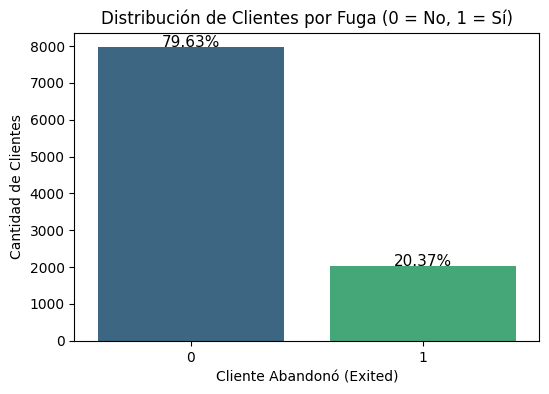

Tasa de Churn general: 20.37%


In [47]:
# 1. Distribución de la Variable Objetivo (Churn/Exited)
plt.figure(figsize=(6, 4))
sns.countplot(x='exited', data=raw_data, palette='viridis')
plt.title('Distribución de Clientes por Fuga (0 = No, 1 = Sí)')
plt.xlabel('Cliente Abandonó (Exited)')
plt.ylabel('Cantidad de Clientes')
total = len(raw_data)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=11)
plt.show()
print(f"Tasa de Churn general: {raw_data['exited'].mean()*100:.2f}%")


<ipython-input-48-9d377bd9994f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')


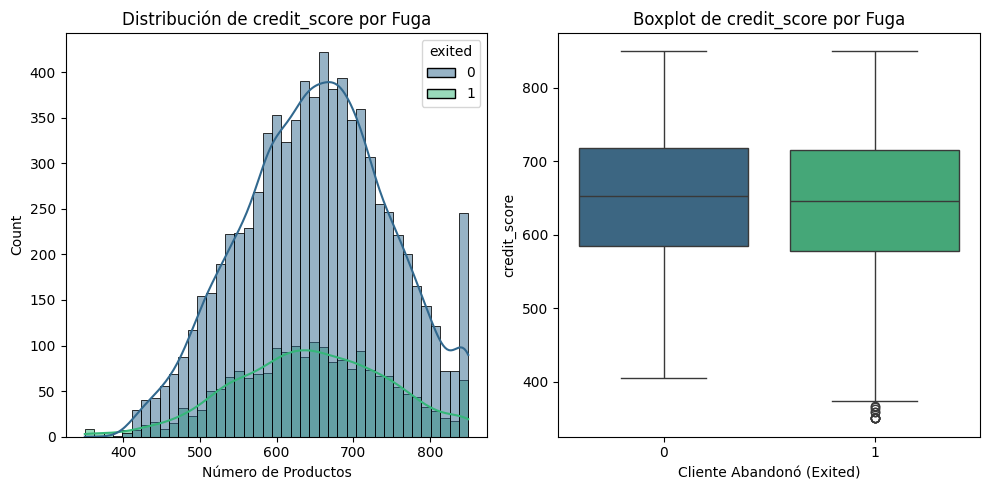

<ipython-input-48-9d377bd9994f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')


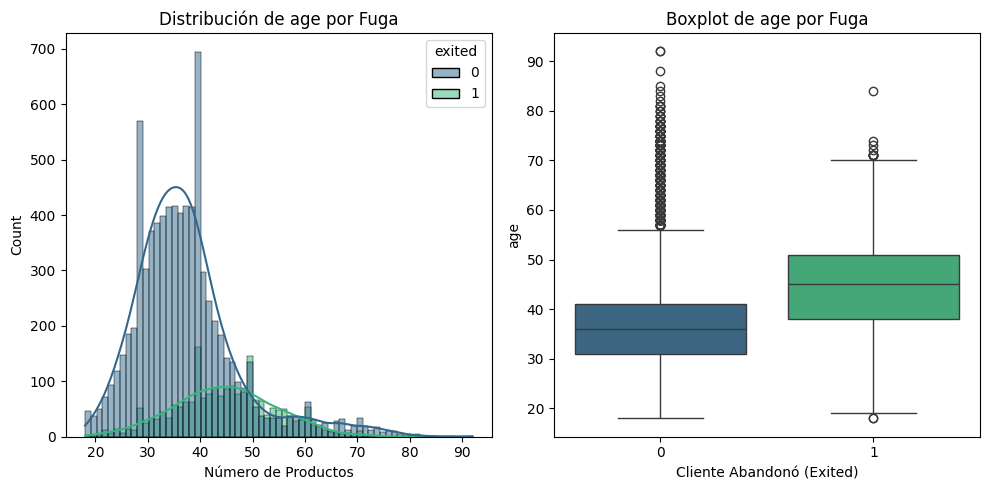

<ipython-input-48-9d377bd9994f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')


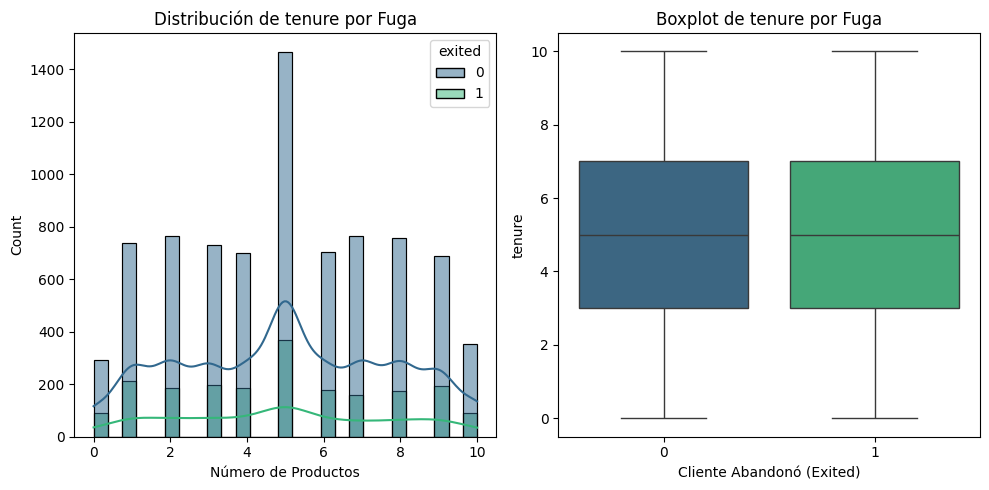

<ipython-input-48-9d377bd9994f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')


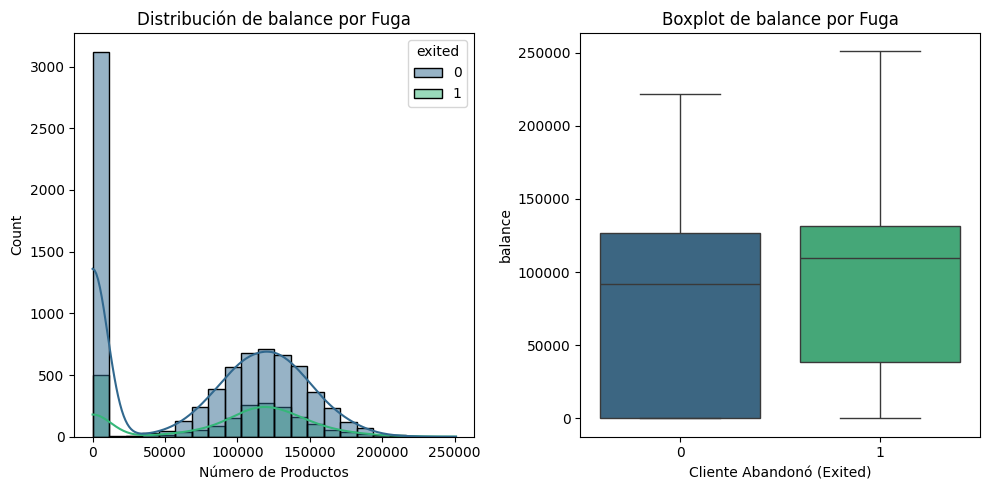

<ipython-input-48-9d377bd9994f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')


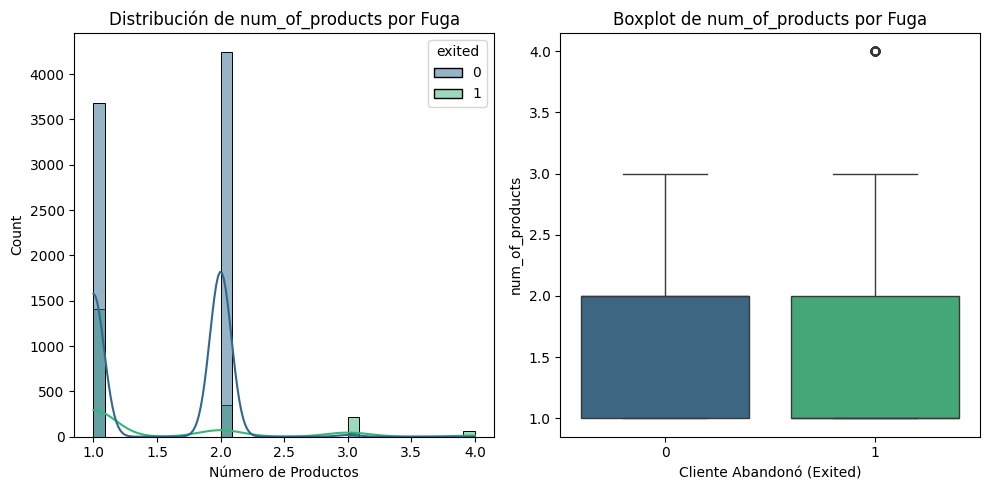

<ipython-input-48-9d377bd9994f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')


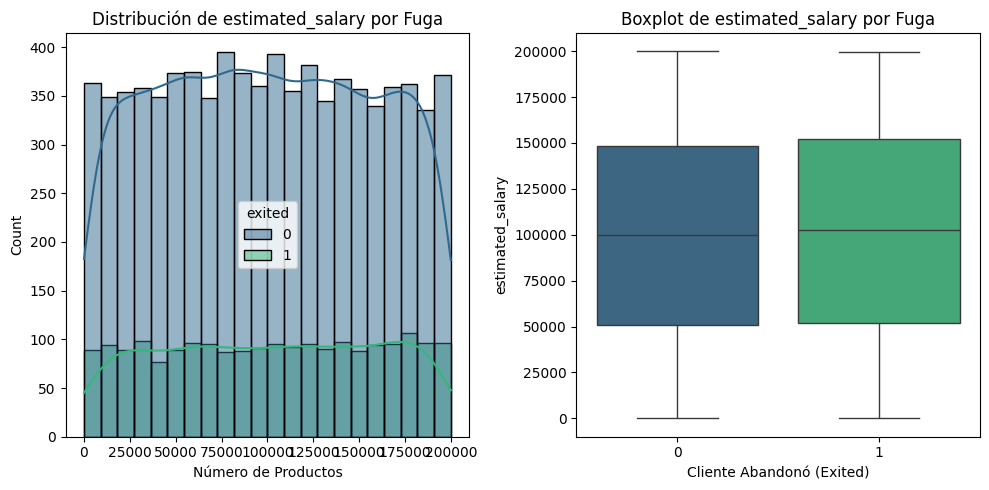

In [48]:
# 2. Distribución de Variables Numéricas vs. Churn
numerical_features_for_eda = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
for col in numerical_features_for_eda:
    plt.figure(figsize=(10, 5))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(data=raw_data, x=col, hue='exited', kde=True, palette='viridis')
    plt.title(f'Distribución de {col} por Fuga')
    plt.xlabel('Número de Productos')


    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=raw_data, y=col, x='exited', palette='viridis')
    plt.title(f'Boxplot de {col} por Fuga')
    plt.xlabel('Cliente Abandonó (Exited)')

    plt.tight_layout()
    plt.show()

<ipython-input-49-edd782a117f7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='exited', data=churn_rate, palette='viridis')


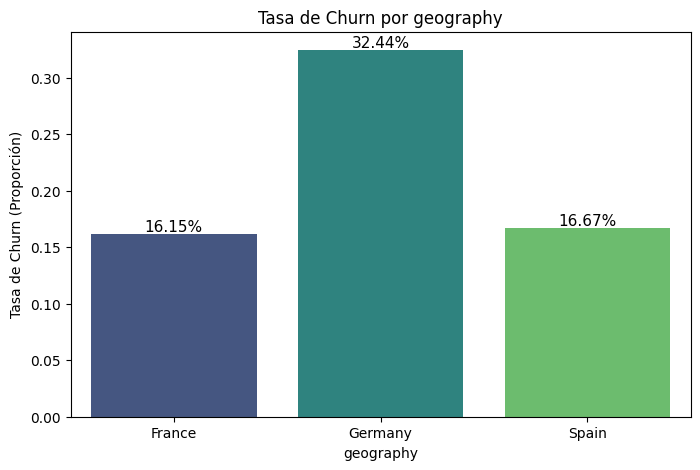

<ipython-input-49-edd782a117f7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='exited', data=churn_rate, palette='viridis')


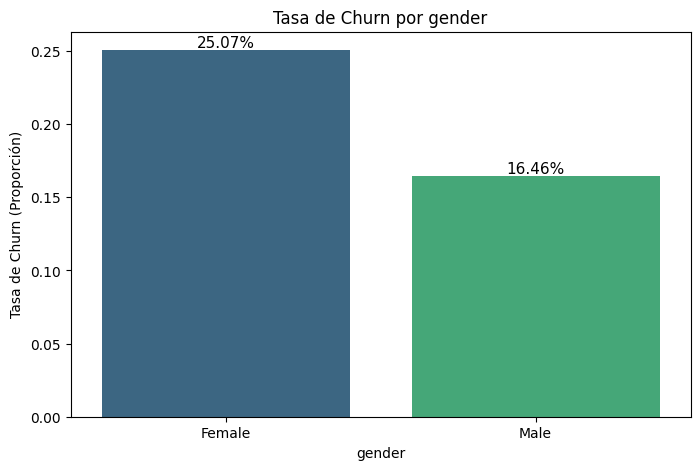

<ipython-input-49-edd782a117f7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='exited', data=churn_rate, palette='viridis')


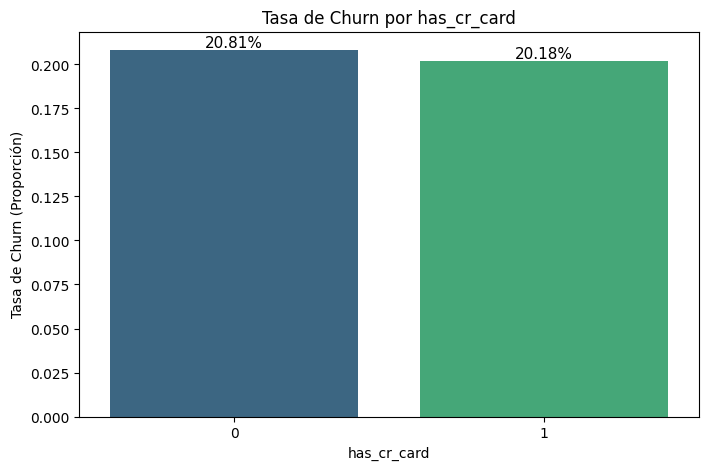

<ipython-input-49-edd782a117f7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='exited', data=churn_rate, palette='viridis')


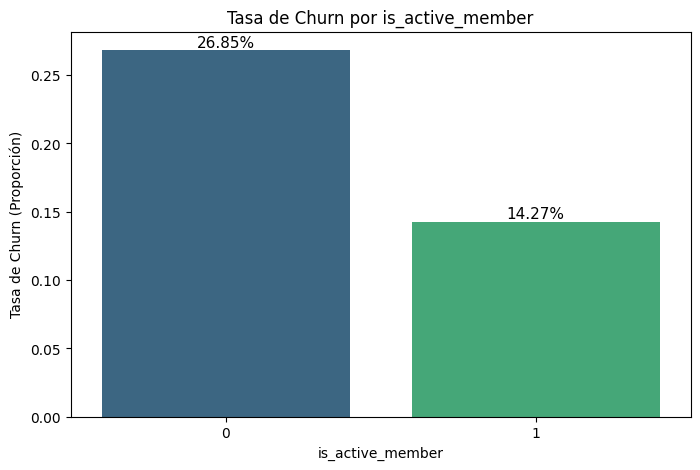

<ipython-input-49-edd782a117f7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='exited', data=churn_rate, palette='viridis')


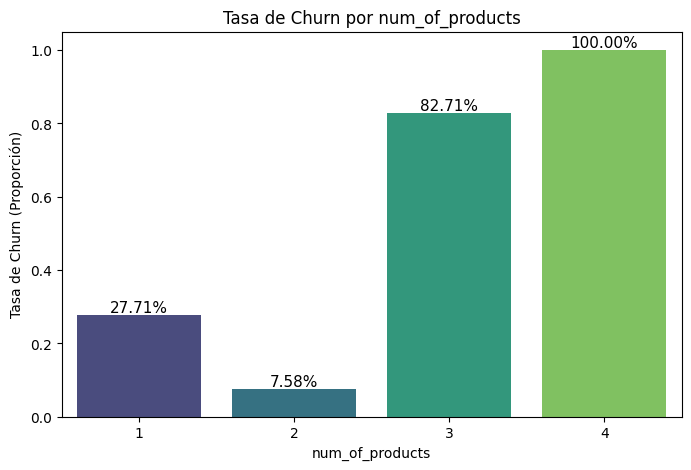

--- Fin EDA Visualizations ---


In [49]:
# 3. Distribución de Variables Categóricas vs. Churn
categorical_features_for_eda = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'num_of_products'] # num_of_products como categórica aquí por pocos valores
for col in categorical_features_for_eda:
    plt.figure(figsize=(8, 5))
    # Calculamos la tasa de churn por categoría
    churn_rate = raw_data.groupby(col)['exited'].mean().reset_index()
    sns.barplot(x=col, y='exited', data=churn_rate, palette='viridis')
    plt.title(f'Tasa de Churn por {col}')
    plt.ylabel('Tasa de Churn (Proporción)')
    plt.xlabel(col)
    ax = plt.gca()
    for p in ax.patches:
      ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:1.2f}%'.format(p.get_height()*100),
              fontsize=11, color='black', ha='center', va='bottom')
    plt.show()
print("--- Fin EDA Visualizations ---")

### Codificación de variables categóricas

In [50]:
# creación de un dataframe para visualizar los tipos de datos
dtypes = pd.DataFrame(
                    raw_data.dtypes,
                    columns=['dtype']
                    )

In [51]:
dtypes

,dtype
row_number,int64
customer_id,int64
surname,object
credit_score,int64
geography,object
gender,object
age,int64
tenure,float64
balance,float64
num_of_products,int64


#### Automatización del proceso para identificar variables categóricas y numéricas

In [52]:
variables_categoricas = list(dtypes[dtypes['dtype'] == 'object'].index)[1:]

In [53]:
variables_categoricas

['geography', 'gender']

In [54]:
variables_numericas = list(dtypes[dtypes['dtype'] != 'object'].index)[2:-1]

In [55]:
variables_numericas

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary']

In [56]:
# estas variables no nos aportan mucho valor para modelar nuestro modelo, así que las apartamos
variables_no_informativas = ['surname', 'row_number', 'customer_id']

In [57]:
# creamos el dataset limpio
preprocessed_data = raw_data.drop(variables_no_informativas, axis=1)

In [58]:
preprocessed_data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


#### One-Hot Encoding

In [59]:
data_for_model = pd.get_dummies(
                                preprocessed_data,
                                drop_first=True,
                                columns=variables_categoricas
                                )

In [60]:
data_for_model # datasat a usar de ahora en adelante

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,False,False,True
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,False,False,True
9997,709,36,7.0,0.00,1,0,1,42085.58,1,False,False,False
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,True,False,True


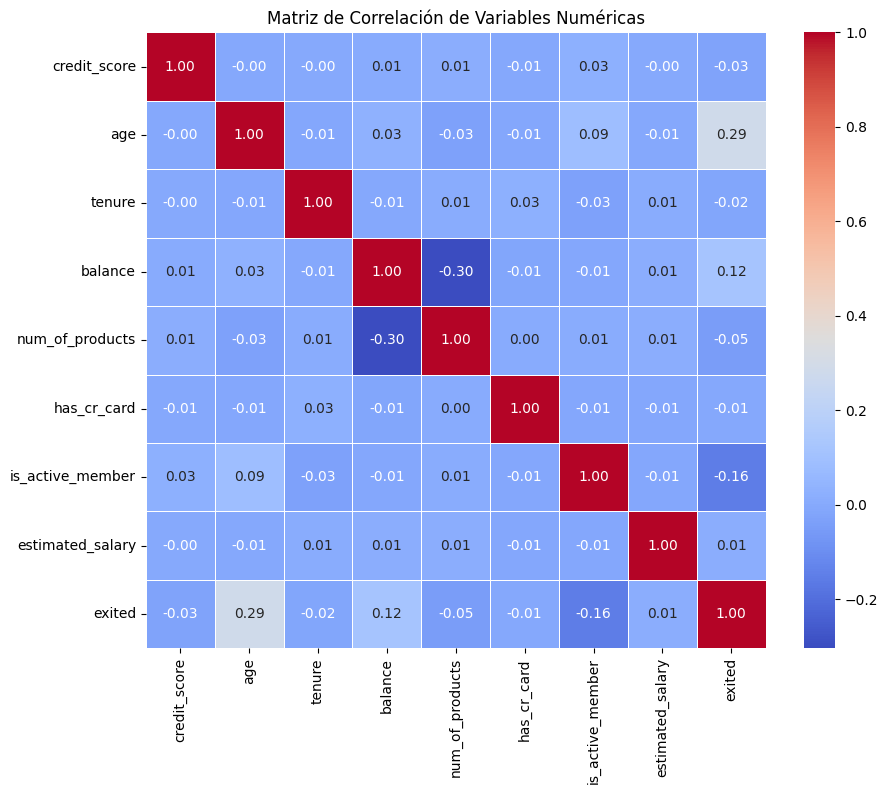

In [61]:
# 4. Matriz de Correlación (solo numéricas)
plt.figure(figsize=(10, 8))
# Usamos data_for_model porque ya tiene OHE y es numérico, pero seleccionamos las originales numéricas + target
corr_cols = variables_numericas + ['exited'] # Asegúrate que 'variables_numericas' esté definida como en tu código
correlation_matrix = data_for_model[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()


**Conclusión**: Se aplicó correctamente la codificación One-Hot Encoding a las variables categóricas como `geography` y `gender`. Permitiendo que el modelo las procesara como variables numéricas sin introducir un orden que no existe en los datos categóricos.

---
## Segmentación del conjunto de datos
- **Entrenamiento** -> para entrenar el modelo
    - Entrenamos varios modelos con este conjunto
- **Validación** -> para tunear los modelos, irlos mejorando poco a poco
    - e.g: árbol de decisión y la profundidad. Cuál es la mejor profundidad para este algoritmo y cuántas ramas necesita.
    - e.g: RandomForest y tuneamos la cantidad de árboles. Cuál cantidad de árboles es la mejor.
    - e.g: Regresión logística
- **Prueba** -> para ver cuál es el mejor de mis modelos tuneados

Separaremos el set de datos en entrenamiento-validación y prueba - 20%
Luego el de entrenamiento-validación en entrenamiento y validación

In [62]:
# 80% entrenamiento-validación y 20% prueba
# separamos conjuntos de datos de entrenamiento-validación y de prueba
df_train_valid, df_test = train_test_split(data_for_model,
                                           test_size=.20,
                                           random_state=12345
                                          )


# 75% entrenamiento-validación y 25% prueba
# separamos el conjunto de entrenamiento en entrenamimento y validación.
df_train, df_valid = train_test_split(df_train_valid,
                                      test_size=.25,
                                      random_state=12345
                                     )

In [63]:
# entrenamiento
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

# validación
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

# prueba
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

In [64]:
# verificamos si las caracteríticas tienen la misma cantidad de columnas
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


**Conclusión**: La división de los datos en conjuntos de entrenamiento (80%), validación (20%) y prueba se realizó de manera adecuada, permitiendo que los datos se utilicen en tres etapas: para entrenar el modelo, ajustar sus hiperparámetros y, finalmente, para realizar la evaluación final en el conjunto de prueba

### Escalado de características

In [65]:
# escalamos las características
scaler = StandardScaler()
scaler.fit(features_train[variables_numericas])

features_train[variables_numericas] = scaler.transform(features_train[variables_numericas])
features_valid[variables_numericas] = scaler.transform(features_valid[variables_numericas])
features_test[['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']] = scaler.transform(features_test[['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']])


print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


**Conclusión**: El escalado de las características numéricas fue un paso importante, especialmente para la regresión logística, que es sensible a las diferencias en la escala de las características. Esto aseguró que todas las variables numéricas fueran tratadas en la misma escala, mejorando la capacidad del modelo para converger.

---
## Análisis del Desequilibrio de clases I
Nos enfocaremos en garantizar que el modelo no esté sesgado hacia una clase en particular.

### Distribución de las clases en el conjunto de entrenamiento

exited
0    4781
1    1219
Name: count, dtype: int64


<ipython-input-66-c21eca6316cc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(target_train, palette='Set2')


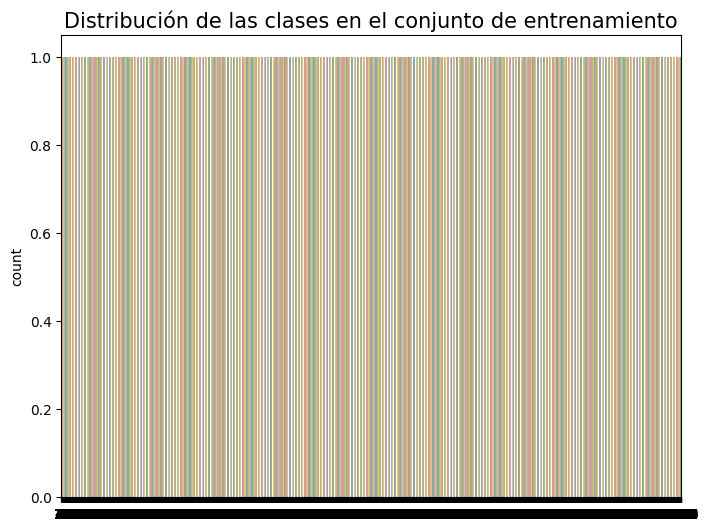

In [66]:
# examinar el equilibrio de clases
class_counts = target_train.value_counts()
print(class_counts)


plt.figure(figsize=(8, 6))
sns.countplot(target_train, palette='Set2')
plt.title('Distribución de las clases en el conjunto de entrenamiento', fontsize=15)
plt.show()

El análisis de la distribución de las clases muestra un fuerte desequilibrio, con una mayor cantidad de clientes que no se fueron del banco (clase 0) en comparación con los que sí se fueron (clase 1). Sin embargo, como pide en las instrucciones de este proyecto, se hará un estudio **sin tomar en cuenta el desequilibrio en las clases**.

Se entrenarán tres modelos:
- un árbol de decisión
- un bosque aleatorio
- una regresión logística

Los compararemos usando la métrica F1

### Decision Tree Model

#### Analizando la mejor profundidad

In [67]:
decision_tree_results = [] # lista para guardar los resultados

best_depth = 0
best_valid_f1 = 0

for depth in range(1, 11):
    # inicialización del modelo
    decision_tree_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)

    # entrenamos el modelo
    decision_tree_model.fit(features_train, target_train)

    # predicciones en el conjunto de validación
    predictions_valid_dt = decision_tree_model.predict(features_valid)

    # valor f1 del conjunto de validación
    valid_f1_dt = f1_score(target_valid, predictions_valid_dt)

    # guardamos resultados
    decision_tree_results.append((depth, valid_f1_dt))

    # Guardar la mejor profundidad
    if valid_f1_dt > best_valid_f1:
        best_valid_f1 = valid_f1_dt
        best_depth = depth

    # Muestras en pantalla
    print(f"Profundidad del árbol: {depth}")
    print(f"Valor F1 Conjunto de validación: {valid_f1_dt}")
    print()

Profundidad del árbol: 1
Valor F1 Conjunto de validación: 0.0

Profundidad del árbol: 2
Valor F1 Conjunto de validación: 0.5037037037037037

Profundidad del árbol: 3
Valor F1 Conjunto de validación: 0.3938223938223938

Profundidad del árbol: 4
Valor F1 Conjunto de validación: 0.43018867924528303

Profundidad del árbol: 5
Valor F1 Conjunto de validación: 0.5488372093023256

Profundidad del árbol: 6
Valor F1 Conjunto de validación: 0.5113043478260869

Profundidad del árbol: 7
Valor F1 Conjunto de validación: 0.5583596214511041

Profundidad del árbol: 8
Valor F1 Conjunto de validación: 0.5398773006134969

Profundidad del árbol: 9
Valor F1 Conjunto de validación: 0.5357142857142857

Profundidad del árbol: 10
Valor F1 Conjunto de validación: 0.5383502170767004



In [68]:
print(f"||| Mejor profundidad: {best_depth} con valor de F1 en validación de: {best_valid_f1} |||")

||| Mejor profundidad: 7 con valor de F1 en validación de: 0.5583596214511041 |||


### Random Forest Model

#### El mejor número de estimadores

In [69]:
random_forest_results =[]

# almacenar el mejor puntaje y el mejor número de estimadores
best_f1 = 0
best_est = 0

for est in range(1, 100):

    # inicializar el modelo RandomForest con el número de estimadores actual
    random_forest_model = RandomForestClassifier(random_state=54321, n_estimators=est)

    # se entrena el modelo en el conjunto de entrenamiento
    random_forest_model.fit(features_train, target_train)

    # evaluar el modelo en el conjunto de validación
    predictions_valid_rf = random_forest_model.predict(features_valid)

    # valor f1 del conjunto de validación
    valid_f1_rf = f1_score(target_valid, predictions_valid_rf)

    # si este modelo tiene mejor puntuación en el conjunto de validación, actualizamos
    if valid_f1_rf > best_f1:
        best_f1 = valid_f1_rf
        best_est = est

    # guardamos los resultados
    random_forest_results.append((est, valid_f1_rf))

# muestras en pantalla del mejor número de estimadores y la precisión obtenida en validación
print(f"El valor F1 más alto del modelo en el conjunto de validación (n_estimators = {best_est}) fue de: {best_f1}")


El valor F1 más alto del modelo en el conjunto de validación (n_estimators = 65) fue de: 0.5696400625978091


### Logistic Regression Model

In [70]:
logistic_regression_model = LogisticRegression(random_state=12345, solver='liblinear')

# entrenando los datos
logistic_regression_model.fit(features_train, target_train)

# predicciones sobre validación
predictions_valid_lr = logistic_regression_model.predict(features_valid)

# f1_score
valid_f1_lr = f1_score(target_valid, predictions_valid_lr)
print(f'El valor F1 de validación para la Regresión Logistica es de un valor de: {valid_f1_lr}')

El valor F1 de validación para la Regresión Logistica es de un valor de: 0.3013182674199623


### El mejor modelo

In [71]:
# conjunto de prueba con el mejor modelo
pred_test = random_forest_model.predict(features_test)

# calcular F1
f1_test = f1_score(target_test, pred_test)
print(f"F1 en conjunto de prueba: {f1_test}")

# calculando AUC-ROC
prob_test = random_forest_model.predict_proba(features_test)[:, 1]
auc_roc_test = roc_auc_score(target_test, prob_test)
print(f"AUC-ROC en conjunto de prueba: {auc_roc_test}")

F1 en conjunto de prueba: 0.5676077265973254
AUC-ROC en conjunto de prueba: 0.8577927288806573


**Conclusión:** Se llegó a la conclusión que si no tenemos en cuenta el desequilibrio de clases, el valor de F1 no llegará a ser mayor que 0.59, que es el valor solicitado de la métrica.

 Este desequilibrio afectó el rendimiento de los modelos sin ajustes, resultando en un F1-score bajo, lo que llevó a la necesidad de aplicar técnicas de balanceo.

Por lo tanto, se continuará con aplicando técnicas para evitar el desequilibrio presentado.

---

## Análisis del desequilibrio de clases II

### Ajustando el peso de clase
#### LogisticRegression

In [72]:
lr_model = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')

lr_model.fit(features_train, target_train)

predictions_valid_lr = lr_model.predict(features_valid)

# F1-Score en el conjunto de validación
f1 = f1_score(target_valid, predictions_valid_lr)
print(f'F1-Score: {f1}')
probabilities_lr_valid = lr_model.predict_proba(features_valid)[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_lr_valid)
print(f'AUC-ROC RandomForest: {auc_roc_lr}')

F1-Score: 0.4750889679715303
AUC-ROC RandomForest: 0.7725740281250446


#### RandomForest

In [73]:
model_rf = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
model_rf.fit(features_train, target_train)

predictions_rf = model_rf.predict(features_valid)

# F1-Score
f1_rf = f1_score(target_valid, predictions_rf)
print(f'F1-Score RandomForest: {f1_rf}')

# AUC-ROC
probabilities_rf_valid = model_rf.predict_proba(features_valid)[:, 1]
auc_roc_rf = roc_auc_score(target_valid, probabilities_rf_valid)
print(f'AUC-ROC RandomForest: {auc_roc_rf}')

F1-Score RandomForest: 0.5933503836317136
AUC-ROC RandomForest: 0.853223317051305


### Comparación Resultados cono solo ajuste de peso de clase

In [74]:
print(f'Logistic Regression F1-Score: {f1}, AUC-ROC: {auc_roc_lr}')
print(f'Random Forest F1-Score: {f1_rf}, AUC-ROC: {auc_roc_rf}')

Logistic Regression F1-Score: 0.4750889679715303, AUC-ROC: 0.7725740281250446
Random Forest F1-Score: 0.5933503836317136, AUC-ROC: 0.853223317051305


**Conclusión**: El modelo de Random Forest fue el mejor en cuanto a F1-score (0.590) y AUC-ROC (0.854), demostrando su capacidad para distinguir entre clientes que abandonan el banco y aquellos que no lo hacen. El ajuste del desequilibrio de clases fue fundamental para lograr estos resultados

---



## Prueba Final con peso de clase
**NOTA**: esta prueba se realizó solo con el peso de clases como técnica para equilibrar las clases

In [75]:
predictions_test = model_rf.predict(features_test)

# calcular el F1-score en el conjunto de prueba
f1_test = f1_score(target_test, predictions_test)
print(f'F1-Score en el conjunto de prueba: {f1_test}')

# calcular el AUC-ROC en el conjunto de prueba
probabilities_test = model_rf.predict_proba(features_test)[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_test)
print(f'AUC-ROC en el conjunto de prueba: {auc_roc_test}')

# comparación entre las métricas
print(f'Comparación - F1: {f1_test}, AUC-ROC: {auc_roc_test}')

F1-Score en el conjunto de prueba: 0.6383981154299175
AUC-ROC en el conjunto de prueba: 0.8661160002441672
Comparación - F1: 0.6383981154299175, AUC-ROC: 0.8661160002441672


**Conclusión**: El F1-score obtenido en el conjunto de prueba fue superior al valor mínimo requerido de 0.59, lo que indica que el modelo ha mejorado su capacidad para identificar correctamente a los clientes que abandonan el banco, manteniendo un balance sólido entre precisión y recall.

El AUC-ROC de 0.8673 indica que el modelo tiene una muy buena capacidad para distinguir entre clientes que abandonarán el banco y aquellos que no lo harán. El valor de AUC-ROC por encima de 0.85 confirma que el modelo no solo predice correctamente las clases, sino que lo hace de manera robusta a lo largo de diferentes umbrales de decisión.

Al comparar ambos resultados:

- **F1-Score** refleja un buen balance entre la precisión y recall, lo que es crucial en este problema, ya que ambos son importantes para predecir correctamente a los clientes que se van

- **AUC-ROC** ofrece una visión completa de la capacidad del modelo para discriminar entre las dos clases. El valor obtenido muestra que el modelo es altamente competente en la clasificación de clientes.

----

<div class="alert alert-block alert-info">
<b>Ajustes luego de la primera iteración. Se entrenaron nuevamente los modelos y se aplicaron técnicas de sobremuestreo y submuestreo</b> <a class=“tocSkip”></a>
</div>

## Análisis del desequilibrio de clases III
Oversampling and Undersampling

### Sobremuestreo

In [76]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

#### Logistic Regression con sobremuestreo

In [77]:
model_over = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_over.fit(features_upsampled, target_upsampled)
predicted_valid_lr_over = model_over.predict(features_valid)

print('F1-Score con Sobremuestreo:', f1_score(target_valid, predicted_valid_lr_over))

F1-Score con Sobremuestreo: 0.4745762711864407


#### Random Forest con sobremuestreo

In [78]:
rf_over = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
rf_over.fit(features_upsampled, target_upsampled)

predictions_rf_over = rf_over.predict(features_valid)

# F1-Score
f1_rf_over = f1_score(target_valid, predictions_rf_over)
print(f'F1-Score RandomForest: {f1_rf_over}')

F1-Score RandomForest: 0.5873015873015873


Tenemos un F1 de 0.593 con RF para sobremuestreo

### Submuestreo

In [79]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

#### Logistic Regression con submuestreo

In [80]:
lr_under = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
lr_under.fit(features_downsampled, target_downsampled)
predicted_valid_lr_under = lr_under.predict(features_valid)

print('F1-Score con Submuestreo:', f1_score(target_valid, predicted_valid_lr_under))

F1-Score con Submuestreo: 0.47100802854594115


#### Random Forest con submuestreo

In [81]:
rf_under = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
rf_under.fit(features_upsampled, target_upsampled)

predictions_rf_under = rf_under.predict(features_valid)

# F1-Score
f1_rf_under = f1_score(target_valid, predictions_rf_under)
print(f'F1-Score RandomForest: {f1_rf_under}')

F1-Score RandomForest: 0.5873015873015873


Tenemos un F1 de 0.593 con RF para submuestreo

### Prueba final sobremuestreo y submuestreo

#### Prueba en conjunto de prueba - Sobremuestreo

In [82]:
# modelo Random Forest entrenado con sobremuestreo
rf_over = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
rf_over.fit(features_upsampled, target_upsampled)

# predicciones en el conjunto de prueba
predictions_rf_over_test = rf_over.predict(features_test)

# F1-Score en el conjunto de prueba
f1_rf_over_test = f1_score(target_test, predictions_rf_over_test)
print(f'F1-Score en conjunto de prueba (Sobremuestreo): {f1_rf_over_test}')

# AUC-ROC en el conjunto de prueba
probabilities_rf_over_test = rf_over.predict_proba(features_test)[:, 1]
auc_roc_rf_over_test = roc_auc_score(target_test, probabilities_rf_over_test)
print(f'AUC-ROC en conjunto de prueba (Sobremuestreo): {auc_roc_rf_over_test}')


F1-Score en conjunto de prueba (Sobremuestreo): 0.6376195536663124
AUC-ROC en conjunto de prueba (Sobremuestreo): 0.8659164978091952


#### Prueba en conjunto de prueba - Submuestreo

In [83]:
# modelo Random Forest entrenado con submuestreo
rf_under = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
rf_under.fit(features_downsampled, target_downsampled)

# Predicciones en el conjunto de prueba
predictions_rf_under_test = rf_under.predict(features_test)

# F1-Score en el conjunto de prueba
f1_rf_under_test = f1_score(target_test, predictions_rf_under_test)
print(f'F1-Score en conjunto de prueba (Submuestreo): {f1_rf_under_test}')

# AUC-ROC en el conjunto de prueba
probabilities_rf_under_test = rf_under.predict_proba(features_test)[:, 1]
auc_roc_rf_under_test = roc_auc_score(target_test, probabilities_rf_under_test)
print(f'AUC-ROC en conjunto de prueba (Submuestreo): {auc_roc_rf_under_test}')


F1-Score en conjunto de prueba (Submuestreo): 0.5372918175235337
AUC-ROC en conjunto de prueba (Submuestreo): 0.8506471174131381


## Comparación resultados pruebas finales

In [84]:
print(f'Comparación de resultados:')
print(f'F1-Score en conjunto de prueba (Sobremuestreo): {f1_rf_over_test}')
print(f'AUC-ROC en conjunto de prueba (Sobremuestreo): {auc_roc_rf_over_test}')

print(f'F1-Score en conjunto de prueba (Submuestreo): {f1_rf_under_test}')
print(f'AUC-ROC en conjunto de prueba (Submuestreo): {auc_roc_rf_under_test}')

Comparación de resultados:
F1-Score en conjunto de prueba (Sobremuestreo): 0.6376195536663124
AUC-ROC en conjunto de prueba (Sobremuestreo): 0.8659164978091952
F1-Score en conjunto de prueba (Submuestreo): 0.5372918175235337
AUC-ROC en conjunto de prueba (Submuestreo): 0.8506471174131381


## Gráficos de Evaluación del modelo final

\n--- Evaluación Gráfica del Modelo Final (Random Forest con Sobremuestreo en Test Set) ---


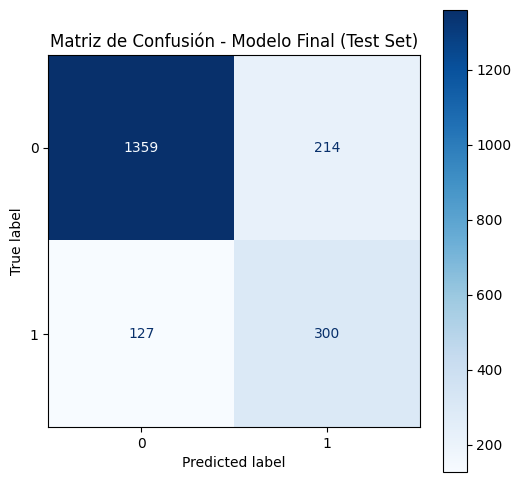

Verdaderos Negativos (TN): 1359 - Clientes correctamente identificados como NO Fuga.
Falsos Positivos (FP):    214 - Clientes incorrectamente identificados como Fuga (Error Tipo I).
Falsos Negativos (FN):    127 - Clientes incorrectamente identificados como NO Fuga (Error Tipo II - ¡Costoso!).
Verdaderos Positivos (TP): 300 - Clientes correctamente identificados como Fuga.
Precision (Test): 0.5837
Recall (Test):    0.7026
F1-Score (Test):  0.6376


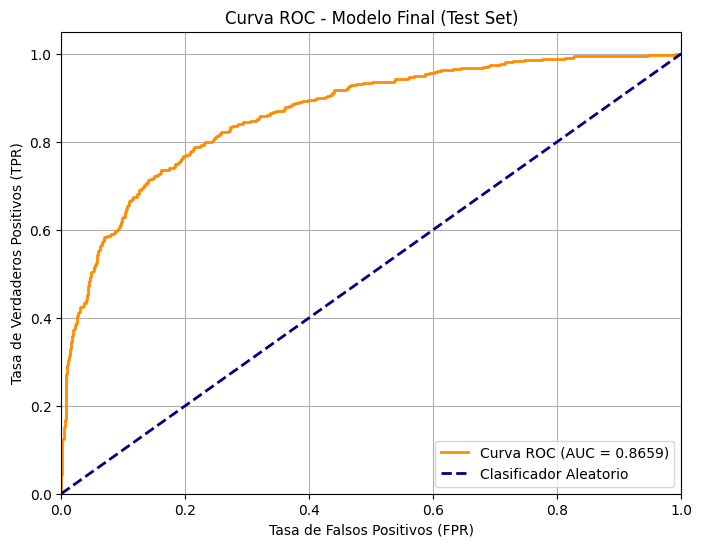

AUC-ROC (Test): 0.8659


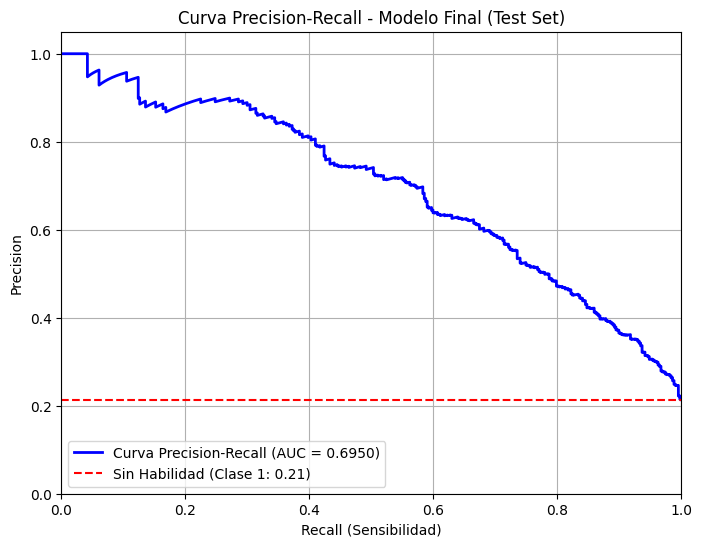

--- Fin Evaluación Gráfica ---


In [85]:
print("\\n--- Evaluación Gráfica del Modelo Final (Random Forest con Sobremuestreo en Test Set) ---")

# Modelo seleccionado: rf_over
# Predicciones en test: predictions_rf_over_test
# Probabilidades en test: probabilities_rf_over_test
# Target real test: target_test

# 1. Matriz de Confusión
cm = confusion_matrix(target_test, predictions_rf_over_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_over.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Matriz de Confusión - Modelo Final (Test Set)')
plt.show()

# Extraer valores para comentarios
tn, fp, fn, tp = cm.ravel()
print(f"Verdaderos Negativos (TN): {tn} - Clientes correctamente identificados como NO Fuga.")
print(f"Falsos Positivos (FP):    {fp} - Clientes incorrectamente identificados como Fuga (Error Tipo I).")
print(f"Falsos Negativos (FN):    {fn} - Clientes incorrectamente identificados como NO Fuga (Error Tipo II - ¡Costoso!).")
print(f"Verdaderos Positivos (TP): {tp} - Clientes correctamente identificados como Fuga.")
precision_test = tp / (tp + fp)
recall_test = tp / (tp + fn)
print(f"Precision (Test): {precision_test:.4f}")
print(f"Recall (Test):    {recall_test:.4f}")
print(f"F1-Score (Test):  {f1_rf_over_test:.4f}") # Ya lo calculaste antes

# 2. Curva ROC y AUC
fpr, tpr, thresholds_roc = roc_curve(target_test, probabilities_rf_over_test)
roc_auc = auc(fpr, tpr) # Ya calculaste auc_roc_rf_over_test

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_roc_rf_over_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Final (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"AUC-ROC (Test): {auc_roc_rf_over_test:.4f}")

# 3. Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(target_test, probabilities_rf_over_test)
pr_auc = auc(recall, precision) # Área bajo la curva PR

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Curva Precision-Recall (AUC = {pr_auc:.4f})')
# Calcular el F1-score para el clasificador sin habilidad (baseline)
no_skill = len(target_test[target_test==1]) / len(target_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label=f'Sin Habilidad (Clase 1: {no_skill:.2f})')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Modelo Final (Test Set)')
plt.legend(loc="lower left")
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

print("--- Fin Evaluación Gráfica ---")

## Gráfica de Importancia de Características

\n--- Importancia de Características (Modelo Final: Random Forest) ---


<ipython-input-86-09cd6192514d>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


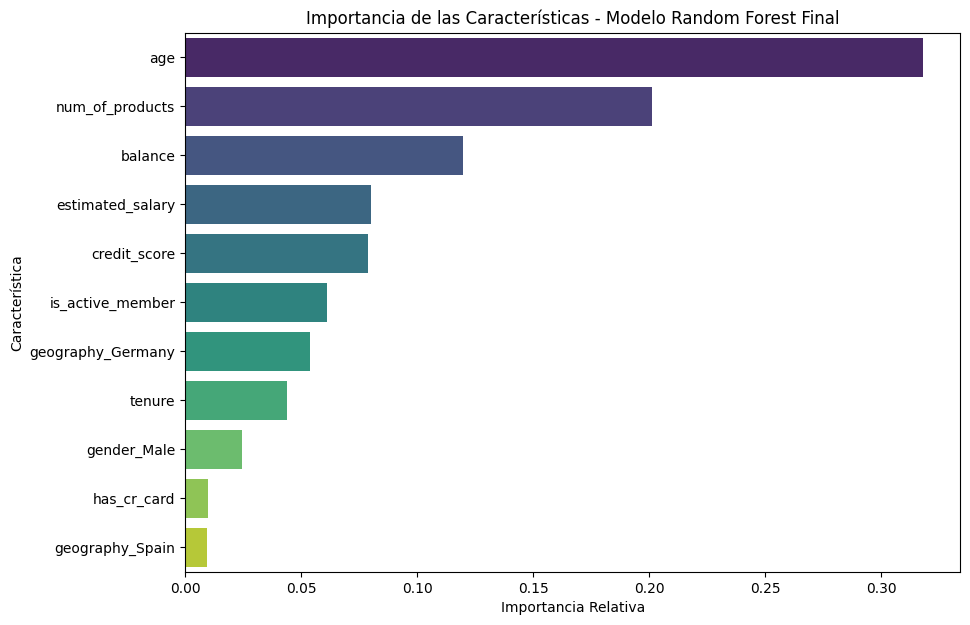

Características más importantes:
              Feature  Importance
1                 age    0.317986
4     num_of_products    0.201067
3             balance    0.119565
7    estimated_salary    0.079947
0        credit_score    0.078795
6    is_active_member    0.061281
8   geography_Germany    0.053818
2              tenure    0.043789
10        gender_Male    0.024345
5         has_cr_card    0.009878
--- Fin Importancia de Características ---


In [86]:
print("\\n--- Importancia de Características (Modelo Final: Random Forest) ---")

# Obtener importancias
importances = rf_over.feature_importances_
# Obtener nombres de características (¡asegúrate de que coincidan con las columnas usadas en el entrenamiento!)
# data_for_model.columns debería tener las columnas correctas ANTES de separar X e y
# Si features_train es un DataFrame de Pandas, puedes usar sus columnas
feature_names = features_train.columns # O data_for_model.drop('exited', axis=1).columns

# Crear un DataFrame para visualizar
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Características - Modelo Random Forest Final')
plt.xlabel('Importancia Relativa')
plt.ylabel('Característica')
plt.show()

print("Características más importantes:")
print(feature_importance_df.head(10)) # Muestra las 10 más importantes

print("--- Fin Importancia de Características ---")

### Conclusión:
- **F1-Score**:

    El modelo entrenado con sobremuestreo obtuvo un **F1-Score** de `0.639`, mientras que el modelo entrenado con submuestreo alcanzó un **F1-Score** de `0.536`.
    Esto indica que el modelo entrenado con sobremuestreo tiene un _mejor equilibrio entre precisión y recall_, lo que significa que identifica más correctamente tanto los clientes que abandonan como los que no lo hacen, en comparación con el modelo entrenado con submuestreo.


- **AUC-ROC:**

    El AUC-ROC del modelo entrenado con sobremuestreo fue `0.868`, en comparación con `0.849` del modelo entrenado con submuestreo.
    Un AUC-ROC más alto indica que el modelo entrenado con sobremuestreo es _mejor para distinguir entre clientes que abandonarán el banco y los que no lo harán_, incluso con diferentes umbrales de decisión.
    
    
- **Balance general:**

    El **sobremuestreo resulta ser la mejor técnica en este caso**. No solo logra un F1-Score más alto, lo que implica una mejor capacidad para predecir de manera balanceada, sino que también obtiene un AUC-ROC superior, lo que indica que el modelo discrimina mejor entre las dos clases.

    Aunque el submuestreo también mejora la capacidad del modelo para manejar el desequilibrio de clases, su rendimiento en F1-Score es inferior, lo que sugiere que está perdiendo información valiosa al reducir la cantidad de datos en la clase mayoritaria.

---
# Conclusiones finales

## Conclusiones Técnicas:
- **Modelo Óptimo**: El algoritmo Random Forest demostró ser el más eficaz para predecir el churn de clientes en Beta Bank, superando a la Regresión Logística y al Árbol de Decisión simple.
- **Impacto del Desequilibrio**: El desequilibrio inherente en los datos (aproximadamente 80% no-churn vs. 20% churn) requirió técnicas de balanceo. El sobremuestreo (Upsampling) de la clase minoritaria, combinado con el Random Forest, produjo los mejores resultados en el conjunto de prueba.
- **Rendimiento Final**: El modelo final (Random Forest con sobremuestreo) alcanzó un F1-Score de 0.639 y un AUC-ROC de 0.868 en datos no vistos (conjunto de prueba). Esto indica:
  - Un buen equilibrio entre precisión (identificar correctamente a los que sí harán churn) y recall (capturar a la mayoría de los que harán churn). El F1-Score supera el objetivo inicial de 0.59.
  - Una excelente capacidad discriminativa (AUC-ROC cercano a 0.9) para diferenciar entre clientes propensos a irse y los que no.
- **Factores Clave del Churn**: El análisis de importancia de características del modelo Random Forest reveló que los principales predictores de la fuga de clientes son:
  - age: La edad del cliente.
  - num_of_products: El número de productos bancarios contratados.
  - balance: El saldo en la cuenta.
  - credit_score: La puntuación crediticia.
  - is_active_member: Si el cliente es considerado miembro activo.
  - geography_Germany: Clientes ubicados en Alemania (basado en la codificación OHE).


## **Conclusiones de Negocio**:
- La fuga de clientes en Beta Bank no es aleatoria; está influenciada por factores demográficos (edad, geografía), de comportamiento (actividad, número de productos) y financieros (saldo, puntuación crediticia) identificables.
- Los clientes más jóvenes o de mediana edad, con un número bajo o muy alto de productos, con saldos elevados (posiblemente buscando mejores rendimientos en otro lugar) o muy bajos (inactividad), que no son miembros activos y/o residen en ciertas geografías (como Alemania en este dataset) parecen tener una mayor propensión al churn. (Ajusta esto según los insights de tus gráficos EDA y de importancia).
- El modelo predictivo desarrollado tiene la capacidad de identificar con una fiabilidad significativa a los clientes en riesgo, permitiendo al banco pasar de una estrategia reactiva a una proactiva de retención.

## Recomendaciones para Beta Bank (Enfoque Consultoría):
1. **Implementación del Modelo**: Integrar el modelo predictivo en los sistemas CRM del banco para generar una puntuación de riesgo de churn para cada cliente de forma periódica (ej. mensual).
2. **Segmentación y Acciones Dirigidas**: Utilizar las puntuaciones de riesgo y los factores clave identificados para segmentar a los clientes y diseñar campañas de retención personalizadas:
  - **Clientes de Alto Riesgo y Alto Valor**: Contacto proactivo por parte de gestores personales, ofertas exclusivas, revisión de condiciones, programas de fidelización mejorados.
  - **Clientes de Alto Riesgo (Perfil Específico)**:
    - Si age es un factor: Ofertas adaptadas a su ciclo de vida financiero.
    - Si num_of_products es bajo: Campañas de cross-selling de productos relevantes con beneficios iniciales.
    - Si is_active_member es bajo: Campañas para reactivar el uso de la cuenta o app, encuestas de satisfacción.
    - Si geography_Germany es alto: Investigar posibles causas específicas del churn en esa región (competencia local, regulación, calidad del servicio percibida) y adaptar la oferta o comunicación.
3. **Monitorización y Mejora Continua**:
  - Monitorizar el rendimiento del modelo en producción y reentrenarlo periódicamente con nuevos datos.
  - Realizar pruebas A/B para medir la efectividad de las diferentes campañas de retención implementadas.
  - Recopilar feedback de los clientes que abandonan (encuestas de salida) para refinar la comprensión de las causas del churn y mejorar el modelo.
